Training rf...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training xgb...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Training lgbm...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Training cat...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training mlp...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
RMSE: 0.8831, MAE: 0.6840, R²: 0.8663


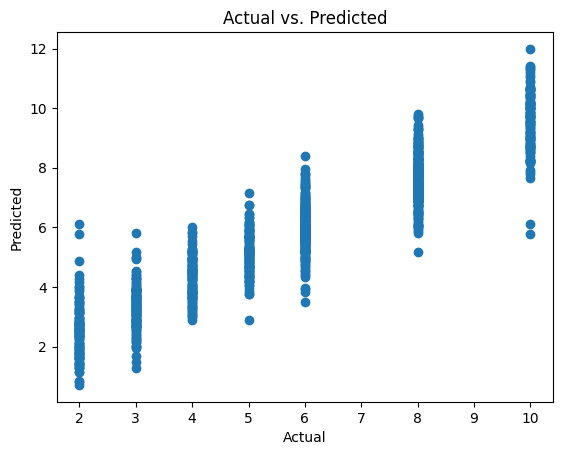

In [ ]:
# Install required packages
!pip install tensorflow scikit-learn matplotlib pandas seaborn xgboost lightgbm catboost --quiet

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('E-learning_Impact_Score1.csv', encoding='ISO-8859-1')

# 1. Data Preprocessing and Encoding (Handle categorical features)
categorical_columns = ['Age', 'Level_of_Education', 'Types_of_content',
                       'Hours_spent_weekly', 'Purpose_of_content',
                       'Learning_preferences', 'E-learning_platforms']
label_encoders = {}

# Label encode categorical columns
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

# Split data into features (X) and target (y)
X = data.drop('E-learning_Impact_Score', axis=1).values
y = data['E-learning_Impact_Score'].values

# 2. Define base models
base_models = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42)),
    ('lgbm', LGBMRegressor(random_state=42,verbose=-1)),
    ('cat', CatBoostRegressor(random_state=42, silent=True)),
    ('mlp', MLPRegressor(random_state=42))
]

# 3. Hyperparameter Grid for Base Models
param_grids = {
    'rf': {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5],
    },
    'xgb': {
        'n_estimators': [100, 300],
        'learning_rate': [0.05, 0.1],
        'max_depth': [6, 10],
        'subsample': [0.8, 1.0],
    },
    'lgbm': {
        'n_estimators': [100, 300],
        'learning_rate': [0.05, 0.1],
        'max_depth': [6, 10],
        'subsample': [0.8, 1.0],
    },
    'cat': {
        'iterations': [100, 300],
        'learning_rate': [0.05, 0.1],
        'depth': [6, 10],
    },
    'mlp': {
        'hidden_layer_sizes': [(64, 32), (128,)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'lbfgs'],
    }
}

# 4. 5-Fold Cross-Validation and Out-of-Fold Predictions for Base Models
def get_oof_predictions(X, y, base_models, param_grids):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    oof_preds = np.zeros((X.shape[0], len(base_models)))

    for i, (name, model) in enumerate(base_models):
        print(f'Training {name}...')

        # Hyperparameter tuning with GridSearchCV
        grid_search = GridSearchCV(model, param_grids[name], cv=kf, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
        grid_search.fit(X, y)

        # Generate out-of-fold predictions
        oof_preds[:, i] = grid_search.predict(X)

    return oof_preds, grid_search.best_params_

# 5. Train Meta-Model (ElasticNet)
def train_meta_model(X_oof, y):
    meta_model = ElasticNet(alpha=0.001, l1_ratio=0.7, random_state=42)
    meta_model.fit(X_oof, y)
    return meta_model

# 6. Hyperparameter Tuning for Meta-Model (ElasticNet)
def hyperparameter_tuning_meta_model(X_oof, y):
    param_grid_meta = {
        'alpha': [0.001, 0.01, 0.1],
        'l1_ratio': [0.5, 0.7, 1.0]
    }
    grid_search = GridSearchCV(ElasticNet(), param_grid_meta, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_oof, y)
    return grid_search.best_estimator_

# 7. Model Evaluation
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    return rmse, mae, r2, y_pred



# 8. Putting Everything Together
# Get out-of-fold predictions
X_oof, best_params = get_oof_predictions(X, y, base_models, param_grids)

# Train the meta-model on out-of-fold predictions
meta_model = train_meta_model(X_oof, y)

# Hyperparameter tuning for meta-model
meta_model_tuned = hyperparameter_tuning_meta_model(X_oof, y)

# Evaluate the tuned model
#evaluate_model(meta_model_tuned, X_oof, y)
rmse, mae, r2, y_pred = evaluate_model(meta_model_tuned, X_oof, y)

plt.scatter(y, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()


